In [1]:
import ee
import geemap
import wxee
import geopandas as gpd
import richdem as rd
import numpy as np
import rioxarray
import xarray as xr

from pathlib import Path

In [2]:
# geemap.show_youtube('N7rK2aV1R4c')

In [3]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [4]:
# Add Earth Engine dataset the NASADEM is a filled 30-m SRTM 
# image = ee.Image("NASA/NASADEM_HGT/001").select("elevation")
image = ee.Image("USGS/SRTMGL1_003").select("elevation")

# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Add Earth Engine DEM to map
# Map.addLayer(image, vis_params, 'SRTM DEM')
basins = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_8")
Map.addLayer(basins, {}, "basins")

In [6]:
roi = ee.FeatureCollection(Map.draw_last_feature)
selected_basins = basins.filterBounds(roi)
# Map.addLayer(selected_basins, {}, "Selected basins")
clipped_image = image.clip(selected_basins.geometry()).set("system:time_start", 0)
Map.addLayer(clipped_image, vis_params, "srtm basins")

In [7]:
ds = clipped_image.wx.to_xarray(scale=30.5)

Downloading:   0%|          | 0.00/1.11M [00:00<?, ?iB/s]

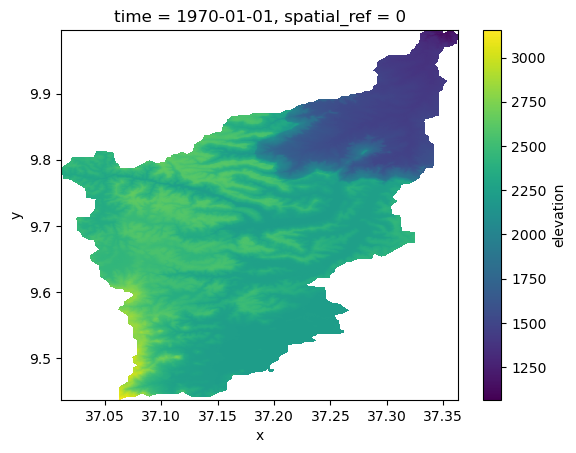

In [8]:
ds = ds.rio.write_crs("epsg:4326")
ds = ds.squeeze()
ds.elevation.plot()

In [9]:
rdsheds = rd.rdarray(ds.elevation.fillna(ds.nodatavals[0]),no_data=ds.nodatavals[0])
rd.FillDepressions(rdsheds, epsilon=True,in_place=True)
ds["filled"] = ds.elevation
ds.filled.data = rdsheds

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Priority-Flood+Epsilon
C Barnes, R., Lehman, C., Mulla, D., 2014. Priority-flood: An optimal depression-filling and watershed-labeling algorithm for digital elevation models. Computers & Geosciences 62, 117–127. doi:10.1016/j.cageo.2013.04.024

c topology = D8
p Setting up boolean flood array matrix...
p Adding cells to the priority queue...
p Performing Priority-Flood+Epsilon...
t succeeded in 0.328788 s==================== ] (99% - 0.0s - 1 threads)
m Cells processed = 2614754
m Cells in pits = 191841


In [ ]:
# mask = ds.elevation.rio.clip(gdf.buffer(.0005))


In [10]:
import cython

In [11]:
%load_ext Cython

In [12]:
%%cython -+
from libcpp.queue cimport queue
from libcpp.vector cimport vector
from libc.math cimport isnan

cdef struct xypoint:
    long x
    long y


#     3 2 1
#     4 X 0
#     5 6 7
cdef int[8] dx = [1, 1, 0, -1, -1, -1, 0, 1]
cdef int[8] dy = [0, 1, 1, 1, 0, -1, -1, -1]
    
def upslope_cells(double[:,:] mask, double[:,:] dem) -> void:
    cdef queue[xypoint] qu
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i,j] != 0:
                qu.push(xypoint(i,j))

    while not qu.empty():
        point = qu.front()
        qu.pop()
        
        for i in range(8):
            x = point.x + dx[i]
            y = point.y + dy[i]
            if x < 0 or x > mask.shape[0]:
                continue
            if y < 0 or y > mask.shape[1]:
                continue
            if mask[x,y] == 0:
                if dem[x,y] > dem[point.x,point.y]:
                    qu.push(xypoint(x,y))
                    mask[x,y] += 1

In [13]:
gdf = geemap.ee_to_geopandas(ee.FeatureCollection(Map.draw_last_feature))
gdf.to_file("roi.shp")
clipped = xr.ones_like(ds.elevation, dtype=np.ubyte).rio.clip(gdf.buffer(0.001))
ds["mask"] = clipped
ds.mask.fillna(0)
ds["mask"] = ds["mask"].fillna(0)
upslope_cells(ds.mask.squeeze().data, ds.filled.squeeze().data)

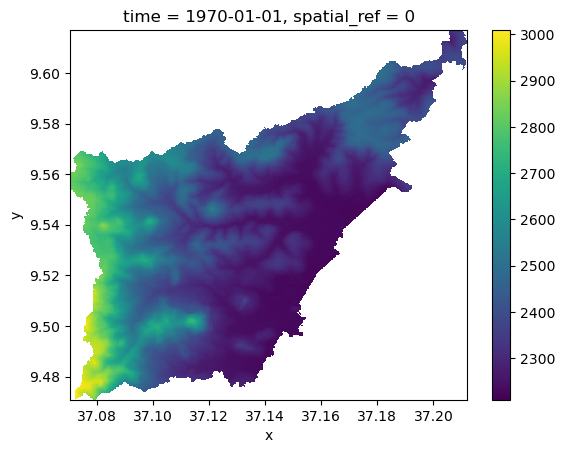

In [14]:
# ds.mask.plot()
# ds.dropna("x",how="all",subset=["mask"]).dropna("y",how="all",subset=["mask"]).mask.plot()
extracted = xr.where(ds.mask != 0, ds.elevation, np.nan).dropna("x",how="all").dropna("y",how="all").rio.write_crs(4326)
extracted.plot()
extracted = extracted.fillna(-9999).rio.write_nodata(-9999)
extracted.rio.to_raster("hadocha_dem.tif")